In [1]:
#Install imblearn
#pip install imblearn --user

In [2]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import numpy as np
import pickle
import sklearn.decomposition
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

#filter warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Load data
df = pd.read_csv('transaction_dataset_features.csv')
df.head()

,FLAG,Avg min between received tnx,Time Diff between first and last (Mins),Unique Sent To Addresses,avg val sent,total transactions (including tnx to create contract,Total ERC20 tnxs
0,0,1093.71,704785.63,118,1.200681,810,265.0
1,0,2958.44,1218216.73,14,0.032844,102,8.0
2,0,2434.02,516729.30,2,1.794308,12,8.0
3,0,15785.09,397555.90,13,70.001834,34,14.0
4,0,10707.77,382472.42,19,0.022688,4619,42.0


In [4]:
#Define X and y
X = df.drop(columns='FLAG')
y = df['FLAG']

In [5]:
#Scale the Data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
#Train/Test Split 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=123)

<b>RANDOM FOREST</b>

In [6]:
#Train model (random forest)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [7]:
#ROC AUC score prior to tuning
scores = cross_val_score(rf, X_train, y_train, scoring = "roc_auc", cv = 5)
print("Mean CV score: " + str(scores.mean()))

Mean CV score: 0.9824754218862308


In [31]:
#Hyperparameter search space

rf_parameters = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 100, 200],
    'criterion': ['gini', 'entropy']
}

#Grid search using 5-fold cross validation
gs = GridSearchCV(RandomForestClassifier(), param_grid = rf_parameters, scoring = "roc_auc", cv = 5)
gs.fit(X_train, y_train)
result = accuracy_score(rf.predict(X_test), y_test)

print(gs.best_params_, gs.best_score_)

{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 100} 0.9852933963433799


In [32]:
best_rf_params = {'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 100}

<b>GRADIENT BOOSTING</b>

In [7]:
#Train model (gradient boosting)
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [8]:
#ROC AUC score prior to tuning
scores = cross_val_score(gb, X_train, y_train, scoring = "roc_auc", cv = 5)
print("Mean CV score: " + str(scores.mean()))

Mean CV score: 0.9812296040053343


In [9]:
#Hyperparameter search space

parameters = {
    'n_estimators': [300, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 100],
    'learning_rate': [0.01, 0.1]
}

#Grid search using 5-fold cross validation
gs = GridSearchCV(GradientBoostingClassifier(), param_grid = parameters, scoring = "roc_auc", cv = 5)
gs.fit(X_train, y_train)
result = accuracy_score(gb.predict(X_test), y_test)

print(gs.best_params_, gs.best_score_)

{'learning_rate': 0.1, 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 300} 0.9851826980406052


In [12]:
best_gb_params = {'learning_rate': 0.1, 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 300}

<b>SUPPORT VECTOR CLASSIFIER</b>

In [13]:
#Train model (SVC)
sv = SVC()
sv.fit(X_train, y_train)

SVC()

In [14]:
#ROC AUC score prior to tuning
scores = cross_val_score(sv, X_train, y_train, scoring = "roc_auc", cv = 5)
print("Mean CV score: " + str(scores.mean()))

Mean CV score: 0.5256475531172654


In [15]:
#Hyperparameter search space

parameters = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1],
}

#Grid search using 5-fold cross validation
gs = GridSearchCV(SVC(), param_grid = parameters, scoring = "roc_auc", cv = 5)
gs.fit(X_train, y_train)
result = accuracy_score(sv.predict(X_test), y_test)

print(gs.best_params_, gs.best_score_)

{'C': 1, 'gamma': 1} 0.9538447001062578


<b>K NEAREST NEIGHBOR CLASSIFIER</b>

In [16]:
#Train model (naive bayes; features are discrete not binary so used MultinomialNB)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [17]:
#ROC AUC score prior to tuning
scores = cross_val_score(knn, X_train, y_train, scoring = "roc_auc", cv = 5)
print("Mean CV score: " + str(scores.mean()))

Mean CV score: 0.9327710266127326


In [18]:
#Hyperparameter search space

parameters = {
    'n_neighbors': [5, 10, 20],
    'p': [1, 2],
    'weights': ['uniform', 'distance']
}

#Grid search using 5-fold cross validation
gs = GridSearchCV(KNeighborsClassifier(), param_grid = parameters, scoring = "roc_auc", cv = 5)
gs.fit(X_train, y_train)
result = accuracy_score(knn.predict(X_test), y_test)

print(gs.best_params_, gs.best_score_)

{'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 0.962992861062857


<b>NAIVE BAYES</b>

In [19]:
#Train model (naive bayes)
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [20]:
#ROC AUC score prior to tuning
scores = cross_val_score(nb, X_train, y_train, scoring = "roc_auc", cv = 5)
print("Mean CV score: " + str(scores.mean()))

Mean CV score: 0.7404139547835573


In [21]:
#Hyperparameter search space

parameters = {
    'var_smoothing': [0.01, 0.1, 0.01, 0.001]
}

#Grid search using 5-fold cross validation
gs = GridSearchCV(GaussianNB(), param_grid = parameters, scoring = "roc_auc", cv = 5)
gs.fit(X_train, y_train)
result = accuracy_score(nb.predict(X_test), y_test)

print(gs.best_params_, gs.best_score_)

{'var_smoothing': 0.1} 0.7442474467439684


<b>LOGISTIC REGRESSION</b>

In [22]:
#Train model (logistic regression)
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [23]:
#ROC AUC score prior to tuning
scores = cross_val_score(lr, X_train, y_train, scoring = "roc_auc", cv = 5)
print("Mean CV score: " + str(scores.mean()))

Mean CV score: 0.7087693400454762


In [24]:
#Hyperparameter search space

parameters = {"C": [0.0001, 0.001, 0.01, 1, 10],
              "max_iter": [250, 500]
}

#Grid search using 5-fold cross validation
gs = GridSearchCV(LogisticRegression(), param_grid = parameters, scoring = "roc_auc", cv = 5)
gs.fit(X_train, y_train)
result = accuracy_score(lr.predict(X_test), y_test)

print(gs.best_params_, gs.best_score_)

{'C': 0.001, 'max_iter': 250} 0.7228336081450719


In [33]:
best_model = RandomForestClassifier(max_depth = best_rf_params['max_depth'], 
                                    max_features = best_rf_params['max_features'], 
                                    n_estimators = best_rf_params['n_estimators'], 
                                    criterion = 'entropy').fit(X_train, y_train)

pickle.dump(best_model, open("best_model.pkl","wb"))

In [13]:
#best_model = GradientBoostingClassifier(learning_rate = best_gb_params['learning_rate'], 
                                    #max_depth = best_gb_params['max_depth'], 
                                    #max_features = best_gb_params['max_features'], 
                                    #n_estimators = best_gb_params['n_estimators']).fit(X_train, y_train)

#pickle.dump(best_model, open("best_model.pkl","wb"))

<b>PRECISION RECALL CURVE</b> 

Text(0, 0.5, '%')

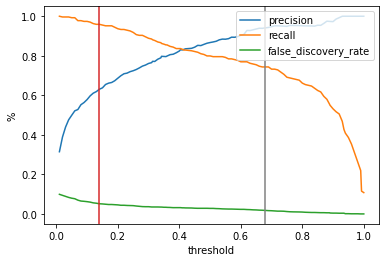

In [7]:
#Create precision recall curve  using best model
#Pick the threshold that gives you the precision and recall that you want, plot it as a vertical line

#Optimized RF model
#gs = GridSearchCV(RandomForestClassifier(), param_grid = rf_parameters, scoring = "roc_auc", cv = 5)
#best_model = RandomForestClassifier().fit(X_train, y_train)
best_model = pickle.load(open("best_model.pkl","rb"))

#Calculate Precision, Recall, FDR, and Threshold
predictions = best_model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

false_discovery_rate = []

for thresh in thresholds:
    y_thresh = best_model.predict_proba(X_test)[:,0] > thresh
    false_discovery_rate_temp = 1 - precision_score(y_test, 1 - y_thresh,  pos_label=0)
    false_discovery_rate.append(false_discovery_rate_temp)

#Clean up chart
false_discovery_rate[-1] = false_discovery_rate[-2]

#move legend to top right
#label fdr
#in cases from fraud, banks care about recall. trying to minimize paying out. err on side of recall, catching fraud matters more than customer experience. 
#fdr, important for customer experience, minum ceiling we can put on how much fraud we can put ppl through, how many false fraud claims we can put ppl through
#explain this in thresholding sectin, discuss with stakeholders, .02 more reasonable but would miss a lot; fdr is the metric of the customer experience which s why its the pertinent metric

plt.plot(thresholds, precision[:-1], color=sns.color_palette()[0]) 
plt.plot(thresholds, recall[:-1], color=sns.color_palette()[1]) 
plt.plot(thresholds, false_discovery_rate, color=sns.color_palette()[2]) 
plt.axvline(x=0.14, color=sns.color_palette()[3])
plt.axvline(x=0.68, color="gray")
plt.legend(('precision', 'recall', 'false_discovery_rate'), loc='upper right', frameon=True) 
plt.xlabel('threshold') 
plt.ylabel('%')


In [35]:
#Precision Recall Table
thresholds = np.linspace(0, 1, 101)

precision = []
recall = []

y_pred = best_model.predict_proba(X_test)[:,1]

for idx, t in enumerate(thresholds):
    p_score = precision_score(y_test, y_pred >= t)
    r_score = recall_score(y_test, y_pred >= t)
    false_discovery_rate_temp = false_discovery_rate[idx]

    print('%.2f %.3f %.3f %.3f' % (t, p_score, r_score, false_discovery_rate_temp))

0.00 0.123 1.000 0.099
0.01 0.315 1.000 0.094
0.02 0.389 0.996 0.089
0.03 0.439 0.996 0.083
0.04 0.476 0.996 0.080
0.05 0.499 0.993 0.077
0.06 0.521 0.993 0.070
0.07 0.528 0.978 0.065
0.08 0.553 0.978 0.064
0.09 0.563 0.974 0.062
0.10 0.578 0.974 0.060
0.11 0.597 0.970 0.056
0.12 0.611 0.963 0.054
0.13 0.619 0.959 0.051
0.14 0.631 0.959 0.050
0.15 0.638 0.955 0.049
0.16 0.655 0.952 0.048
0.17 0.661 0.952 0.048
0.18 0.665 0.952 0.047
0.19 0.674 0.944 0.046
0.20 0.687 0.937 0.044
0.21 0.699 0.933 0.044
0.22 0.709 0.933 0.043
0.23 0.712 0.929 0.042
0.24 0.720 0.926 0.042
0.25 0.724 0.918 0.040
0.26 0.731 0.907 0.038
0.27 0.739 0.903 0.037
0.28 0.748 0.903 0.037
0.29 0.753 0.896 0.037
0.30 0.761 0.888 0.035
0.31 0.765 0.885 0.035
0.32 0.771 0.877 0.035
0.33 0.783 0.870 0.035
0.34 0.790 0.866 0.035
0.35 0.796 0.855 0.035
0.36 0.799 0.855 0.034
0.37 0.806 0.848 0.034
0.38 0.808 0.844 0.033
0.39 0.815 0.836 0.033
0.40 0.824 0.836 0.032
0.41 0.832 0.829 0.032
0.42 0.835 0.829 0.032
0.43 0.838 

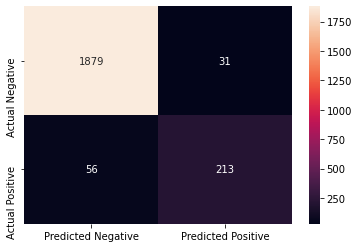

In [27]:
#Confusion matrix for best random forest model
gs = GridSearchCV(RandomForestClassifier(), param_grid = rf_parameters, scoring = "roc_auc", cv = 5)
best_model = gs.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

pl = pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns = ['Predicted Negative', 'Predicted Positive'], 
             index = ['Actual Negative', 'Actual Positive'])

sns.heatmap(pl, annot=True, fmt='.4g')
plt.show()

In [28]:
#Classification Report for best random forest model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1910
           1       0.87      0.79      0.83       269

    accuracy                           0.96      2179
   macro avg       0.92      0.89      0.90      2179
weighted avg       0.96      0.96      0.96      2179



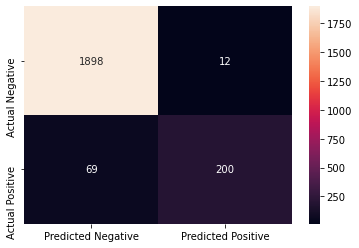

In [37]:
#Confusion Matrix (false discovery rate = 0.02; threshold = 0.68)
#precision = 0.942, recall = 0.743

threshold = 0.68

y_pred = best_model.predict_proba(X_test)[:,1] > threshold

pl2 = pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

sns.heatmap(pl2, annot=True, fmt='.4g')
plt.show()

In [38]:
#Classification Report (false discovery rate = 0.02; threshold = 0.68)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1910
           1       0.94      0.74      0.83       269

    accuracy                           0.96      2179
   macro avg       0.95      0.87      0.91      2179
weighted avg       0.96      0.96      0.96      2179



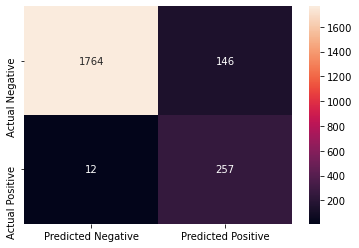

In [39]:
#Confusion Matrix (false discovery rate = 0.05; threshold = 0.14) 
#precision = 0.631, recall = 0.959
threshold = 0.14

y_pred = best_model.predict_proba(X_test)[:,1] > threshold

pl2 = pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

sns.heatmap(pl2, annot=True, fmt='.4g')
plt.show()

In [40]:
#Classification Report (false discovery rate = 0.05; threshold = 0.14)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      1910
           1       0.64      0.96      0.76       269

    accuracy                           0.93      2179
   macro avg       0.82      0.94      0.86      2179
weighted avg       0.95      0.93      0.93      2179

